<hr style=" border:none; height:3px;">
<h1>
<center>Distributed Data Processing with Apache Spark</center>
</h1>
<hr style=" border:none; height:3px;">


In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark
! pip install pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graph

In [ ]:
import pyspark
from pyspark.sql.functions import isnull, when, count, col
from pyspark.sql import SparkSession

In [ ]:
spark_session = SparkSession \
    .builder \
    .enableHiveSupport() \
    .appName('World Cities Population')\
    .getOrCreate()

In [ ]:
spark_session

In [ ]:
PATH = '/content/drive/MyDrive/projects/TP_big_data/worldcitiespop.txt.gz'
data = spark_session.read.option("header","true").option("inferSchema","true").csv(PATH)

In [ ]:
data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- AccentCity: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Population: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [ ]:
data.show(10)

+-------+------------------+------------------+------+----------+----------+---------+
|Country|              City|        AccentCity|Region|Population|  Latitude|Longitude|
+-------+------------------+------------------+------+----------+----------+---------+
|     ad|             aixas|             Aix�s|    06|      null|42.4833333|1.4666667|
|     ad|        aixirivali|        Aixirivali|    06|      null|42.4666667|      1.5|
|     ad|        aixirivall|        Aixirivall|    06|      null|42.4666667|      1.5|
|     ad|         aixirvall|         Aixirvall|    06|      null|42.4666667|      1.5|
|     ad|          aixovall|          Aixovall|    06|      null|42.4666667|1.4833333|
|     ad|           andorra|           Andorra|    07|      null|      42.5|1.5166667|
|     ad|  andorra la vella|  Andorra la Vella|    07|     20430|      42.5|1.5166667|
|     ad|   andorra-vieille|   Andorra-Vieille|    07|      null|      42.5|1.5166667|
|     ad|           andorre|           Ando

In [ ]:
data.count()

3173958

In [ ]:
data.columns

['Country',
 'City',
 'AccentCity',
 'Region',
 'Population',
 'Latitude',
 'Longitude']

In [ ]:
data.dtypes

[('Country', 'string'),
 ('City', 'string'),
 ('AccentCity', 'string'),
 ('Region', 'string'),
 ('Population', 'int'),
 ('Latitude', 'double'),
 ('Longitude', 'double')]

 <h2>Data Cleaning</h2>

In [ ]:
data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()

+-------+----+----------+------+----------+--------+---------+
|Country|City|AccentCity|Region|Population|Latitude|Longitude|
+-------+----+----------+------+----------+--------+---------+
|      0|   0|         0|     8|   3125978|       0|        0|
+-------+----+----------+------+----------+--------+---------+



the data has many missing values!, since 98% of the data is missing, filling the NaN values using Interploation will not give a good estimation, because of that we will proceed by dropping the NaN values.

In [ ]:
data = data.dropna()

In [ ]:
data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()

+-------+----+----------+------+----------+--------+---------+
|Country|City|AccentCity|Region|Population|Latitude|Longitude|
+-------+----+----------+------+----------+--------+---------+
|      0|   0|         0|     0|         0|       0|        0|
+-------+----+----------+------+----------+--------+---------+



<h2>Statistics (min, max, sum , average)</h2>

In [ ]:
import pyspark.sql.functions as F

In [ ]:
data.agg(F.max(data.Population), F.min(data.Population), F.avg(data.Population), F.sum(data.Population)).show()

+---------------+---------------+-----------------+---------------+
|max(Population)|min(Population)|  avg(Population)|sum(Population)|
+---------------+---------------+-----------------+---------------+
|       31480498|              7|47719.57063359733|     2289584999|
+---------------+---------------+-----------------+---------------+



<h2>Histogram of frequencies of the populations of the cities</h2>

In [ ]:
! pip install pyspark_dist_explore

In [ ]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
bins = list(np.logspace(0,7, num = 7))

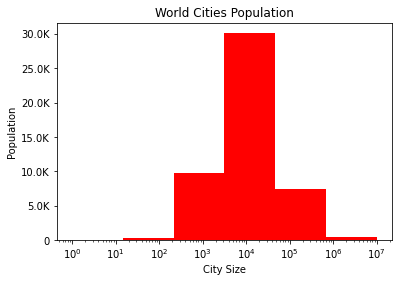

In [ ]:
fig, ax = plt.subplots()
hist(ax, data.select('Population'), bins = bins, color=['red'])
ax.set_title('World Cities Population')
ax.set_xscale('log')
ax.set_xlabel('City Size')
ax.set_ylabel('Population')
plt.show()
